In [18]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import h5py
path = '/z/omarioni/gradients/_simulations/snap_127/'
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
def printname(name):
    print (name)
snap.visit(printname)

Center
Drk
Drk/Coordinates
Drk/IDs
Drk/Masses
Drk/Potential
Drk/Velocities
Gas
Gas/Coordinates
Gas/IDs
Gas/Masses
Gas/Metallicity
Gas/Potential
Gas/Total_Metallicity
Gas/Velocities
Omega_0
Omega_Baryon
Omega_Lambda
Redshift
Str
Str/Birth_Density
Str/Birth_Position
Str/Birth_Velocities
Str/Coordinates
Str/FormationTime
Str/IDs
Str/Masses
Str/Metallicity
Str/Potential
Str/Total_Metallicity
Str/Velocities
Time
h


In [6]:
snap = h5py.File(path + 'subhalo_000.h5py', 'r')
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

print ('h = ',h)
print ('Omega Lambda = ', Om_L)
print ('Omega Matter = ', Om_M)

h =  0.6777
Omega Lambda =  0.682
Omega Matter =  0.318


In [3]:
%matplotlib

Using matplotlib backend: agg


In [27]:
# import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines

path = '/z/omarioni/gradients/_simulations/snap_127/'

subh = (0,1,3,4,5)

# for j in range(0,1):
j= 0
snap = h5py.File(path + 'subhalo_'+str('%03d'%subh[j])+'.h5py', 'r')

aexp = snap['/Time'][()]
h    = snap['/h'][()]
Om_L = snap['/Omega_Lambda'][()]
Om_M = snap['/Omega_0'][()]

pstr = snap['/Str/Coordinates'][()]
mstr = snap['/Str/Masses'][()]
vstr = snap['/Str/Velocities'][()]

met  = snap['/Str/Metallicity'][()]
sft  = snap['/Str/FormationTime'][()]

FeH = met[:,8]/met[:,0]
age = time.conv2(sft, h, Om_L, Om_M)

xstr = pstr[:,0]*aexp/h
ystr = pstr[:,1]*aexp/h
zstr = pstr[:,2]*aexp/h
rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

v_x = vstr[:,0] *np.sqrt(aexp)
v_y = vstr[:,1] *np.sqrt(aexp)
v_z = vstr[:,2] *np.sqrt(aexp)

#----------------------masas----------------------------
mstr = mstr/h

veloc,=np.where(rstr < 3)

#----------componentes de la velocidad del centro de masa------------
vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

vx = v_x - vxcm
vy = v_y - vycm
vz = v_z - vzcm

e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,5)

xn_str = e1x*xstr + e1y*ystr + e1z*zstr
yn_str = e2x*xstr + e2y*ystr + e2z*zstr
zn_str = e3x*xstr + e3y*ystr + e3z*zstr

Rstr = np.sqrt(xn_str**2 + yn_str**2)

mask, = np.where((Rstr <= 50) & (zn_str <= 5) & (zn_str >-5))
# mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))

nbin = 15
# med_R,nodo_R = bines.rbin1(Rstr[mask],nbin)
nodo_R = np.linspace(0,50,nbin)
med_R = nodo_R

age_4,  = np.where((age[mask] > 3.5) & (age[mask] < 4.5))
age_8,  = np.where((age[mask] > 7.5) & (age[mask] < 8.5))
age_10, = np.where((age[mask] > 9.5) & (age[mask] < 10.5))

rr = Rstr[mask]
rr4 = rr[age_4]
rr8 = rr[age_8]
rr10 = rr[age_10]

zz = zn_str[mask]
z4  = zz[age_4]
z8  = zz[age_8]
z10 = zz[age_10]

mass = mstr[mask]
M4 = mass[age_4]
M8 = mass[age_8]
M10 = mass[age_10]


z4a  = np.zeros(nbin)
z8a  = np.zeros(nbin)
z10a = np.zeros(nbin)

for i in range(0,nbin-1):
    zetas4,  = np.where((rr4 >= nodo_R[i])  & (rr4 < nodo_R[i+1])  & (z4 > 0))
    zetas8,  = np.where((rr8 >= nodo_R[i])  & (rr8 < nodo_R[i+1])  & (z8 > 0))
    zetas10, = np.where((rr10 >= nodo_R[i]) & (rr10 < nodo_R[i+1]) & (z10 > 0))

    zz4  = np.argsort(z4[zetas4])
    zz8  = np.argsort(z8[zetas8])
    zz10 = np.argsort(z10[zetas10])
    
    Mbin_4  = np.cumsum(M4[zetas4][zz4])
    Mbin_8  = np.cumsum(M8[zetas8][zz8])
    Mbin_10 = np.cumsum(M10[zetas10][zz10])
    
    kk4,  = np.where(Mbin_4  < Mbin_4[-1]/2)
    kk8,  = np.where(Mbin_8  < Mbin_8[-1]/2)
    kk10, = np.where(Mbin_10 < Mbin_10[-1]/2)
    
    zeta4  = z4[zetas4][zz4]
    zeta8  = z8[zetas8][zz8]
    zeta10 = z10[zetas10][zz10]

    z4a[i]  = zeta4[kk4][-1]
    z8a[i]  = zeta8[kk8][-1]
    z10a[i] = zeta10[kk10][-1]


/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater
/z/omarioni/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less


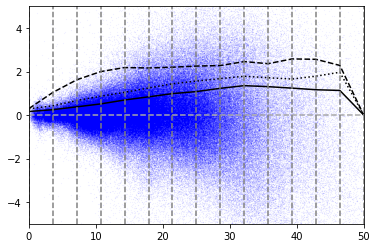

In [31]:
import matplotlib.pyplot as plt
# mask3, = np.where((Rstr < 50) & (zn_str < 30) & (zn_str > -30))
# plt.plot(Rstr[mask],zn_str[mask], '.k',markersize=0.05,alpha =0.7)
# plt.plot(rr4,z4, '.r',markersize=0.05,alpha=0.7)
# plt.plot(rr8,z8, '.c',markersize=0.05, alpha= 0.7)
plt.plot(rr10,z10, '.b',markersize=0.05, alpha= 0.7)
plt.plot(med_R,z4a,ls='--',color='k')
plt.plot(med_R,z8a,ls=':',color='k')
plt.plot(med_R,z10a,ls='-',color='k')
plt.axhline(y=0,ls='--',color='darkgray')
for i in range(len(med_R)):
    plt.axvline(x=med_R[i],ls='--',color='gray')
plt.ylim(-5,5)
plt.xlim(0,50)
plt.show()

In [168]:
print (z10a)

[0.59001565 0.37430674 0.08027193 0.61642742 0.85036403 0.60880661
 0.02165842 0.07126015 0.49309099 2.08326912 1.82632685 1.10449982
 0.63304985 0.47773719 0.        ]


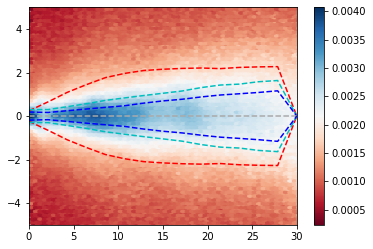

In [17]:
import matplotlib.pyplot as plt
mask2, = np.where((Rstr < 50) & (zn_str < 5) & (zn_str > -5))
plt.hexbin(Rstr[mask2],zn_str[mask2],FeH[mask2],cmap='RdBu')
plt.plot(med_R,z4a,ls='--',color='r')
plt.plot(med_R,z8a,ls='--',color='c')
plt.plot(med_R,z10a,ls='--',color='b')
plt.axhline(y=0,ls='--',color='darkgray')
plt.plot(med_R,-z4a,ls='--',color='r')
plt.plot(med_R,-z8a,ls='--',color='c')
plt.plot(med_R,-z10a,ls='--',color='b')
plt.ylim(-5,5)
plt.xlim(0,30)
plt.colorbar()
plt.show()

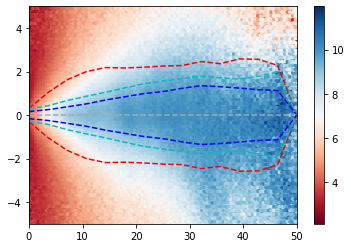

In [30]:
import matplotlib.pyplot as plt
plt.hexbin(Rstr[mask2],zn_str[mask2],age[mask2],cmap='RdBu')
plt.plot(med_R,z4a,ls='--',color='r')
plt.plot(med_R,z8a,ls='--',color='c')
plt.plot(med_R,z10a,ls='--',color='b')
plt.axhline(y=0,ls='--',color='darkgray')
plt.plot(med_R,-z4a,ls='--',color='r')
plt.plot(med_R,-z8a,ls='--',color='c')
plt.plot(med_R,-z10a,ls='--',color='b')
plt.ylim(-5,5)
plt.xlim(0,50)
plt.colorbar()
plt.show()

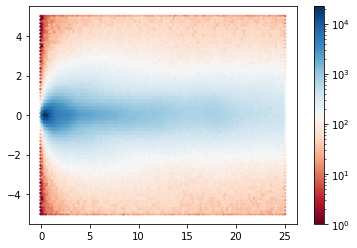

In [38]:
import matplotlib.pyplot as plt
plt.hexbin(Rstr[mask],zn_str[mask],cmap='RdBu',bins='log')
plt.colorbar()

In [10]:
plt.close()

(array([100926., 378722., 678139., 839371., 884780., 956852., 729033.,
        502959., 356501., 292605.]),
 array([ 0.16308884,  1.5152293 ,  2.86737   ,  4.2195106 ,  5.571651  ,
         6.9237914 ,  8.275932  ,  9.628073  , 10.980213  , 12.332354  ,
        13.684494  ], dtype=float32),
 <a list of 10 Patch objects>)

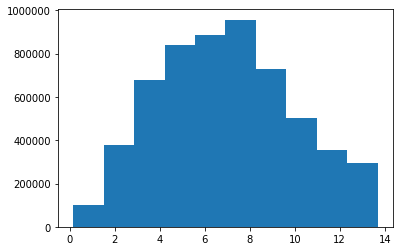

In [16]:
plt.hist(age)

In [79]:
nodo_R = np.linspace(0,25,20)
med_R = nodo_R[:19]


In [81]:
print(nodo_R)

[ 0.          1.31578947  2.63157895  3.94736842  5.26315789  6.57894737
  7.89473684  9.21052632 10.52631579 11.84210526 13.15789474 14.47368421
 15.78947368 17.10526316 18.42105263 19.73684211 21.05263158 22.36842105
 23.68421053 25.        ]


In [82]:
print(med_R)

[ 0.          1.31578947  2.63157895  3.94736842  5.26315789  6.57894737
  7.89473684  9.21052632 10.52631579 11.84210526 13.15789474 14.47368421
 15.78947368 17.10526316 18.42105263 19.73684211 21.05263158 22.36842105
 23.68421053]


(array([4.810000e+02, 2.812480e+05, 2.666375e+06, 2.265903e+06,
        4.783120e+05, 6.193700e+04, 1.213300e+04, 4.625000e+03,
        1.483000e+03, 3.570000e+02]),
 array([1.3971096e-07, 8.3924590e-07, 1.5387809e-06, 2.2383158e-06,
        2.9378507e-06, 3.6373858e-06, 4.3369205e-06, 5.0364556e-06,
        5.7359907e-06, 6.4355254e-06, 7.1350605e-06], dtype=float32),
 <a list of 10 Patch objects>)

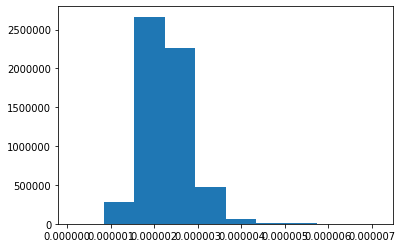

In [140]:
plt.hist(mstr)